# Import packages

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
pp = pprint.PrettyPrinter(indent=1)

import os
import time
import copy
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import ttest_rel
from datetime import timedelta
from ipynb.fs.defs.research import to_tensor, normalise, reshape_tsr, CryptoImageDataset, \
ModelSaver, EarlyStoppingValidator, ModelTrainerTester, plot_learning_curves, plot_conf_matx,\
CNNGRU, CNN, GRU, ExecutionHandler

In [2]:
RANDOM_SEED = 11919925
BATCH_SIZE = 256
LR = 1e-3
TIMEPERIOD = 30
NUM_LOOPS = 30
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

TRAIN_CUTOFF = pd.to_datetime("2021-07-01 00:00:00+00:00")
VAL_CUTOFF = pd.to_datetime("2023-01-01 00:00:00+00:00")

In [3]:
btc = pd.read_feather('./datasets/BTC_USDT-1h-test.feather')
eth = pd.read_feather('./datasets/ETH_USDT-1h-test.feather')
bnb = pd.read_feather('./datasets/BNB_USDT-1h-test.feather')

# BTC Dataset

## Open statistics files

In [4]:
with open('./statistics/BTC_CNNGRU_allstats.json') as f:
    BTC_CNNGRU_allstats = json.load(f)

with open('./statistics/BTC_CNN_allstats.json') as f:
    BTC_CNN_allstats = json.load(f)
    
with open('./statistics/BTC_GRU_allstats.json') as f:
    BTC_GRU_allstats = json.load(f)

## Reporting

In [5]:
def print_stats_per_class(arr):
    """
    Convenience helper function to print statistics per class.
    """
    print(np.mean(arr, axis=0))
    print(np.var(arr, axis=0))
    print(np.min(arr, axis=0))
    print(np.median(arr, axis=0))
    print(np.max(arr, axis=0))
    

def print_stats(lst):
    arr = np.array(lst)
    print(np.mean(arr))
    print(np.var(arr))
    print(np.min(arr))
    print(np.median(arr))
    print(np.max(arr))

### Creating lists

In [6]:
BTC_CNNGRU_test_precision = []
BTC_CNNGRU_test_recall = []
BTC_CNNGRU_test_f1_score = []
BTC_CNNGRU_test_annualised_returns = []

BTC_CNN_test_precision = []
BTC_CNN_test_recall = []
BTC_CNN_test_f1_score = []
BTC_CNN_test_annualised_returns = []

BTC_GRU_test_precision = []
BTC_GRU_test_recall = []
BTC_GRU_test_f1_score = []
BTC_GRU_test_annualised_returns = []

for i in range(NUM_LOOPS):
    BTC_CNNGRU_test_precision.append(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["avg_macro"]["test"]["precision"])
    BTC_CNNGRU_test_recall.append(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["avg_macro"]["test"]["recall"])
    BTC_CNNGRU_test_f1_score.append(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["avg_macro"]["test"]["f1_score"])
    BTC_CNNGRU_test_annualised_returns.append(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["annualised_returns"])
    
    BTC_CNN_test_precision.append(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["avg_macro"]["test"]["precision"])
    BTC_CNN_test_recall.append(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["avg_macro"]["test"]["recall"])
    BTC_CNN_test_f1_score.append(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["avg_macro"]["test"]["f1_score"])
    BTC_CNN_test_annualised_returns.append(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["annualised_returns"])
    
    BTC_GRU_test_precision.append(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["avg_macro"]["test"]["precision"])
    BTC_GRU_test_recall.append(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["avg_macro"]["test"]["recall"])
    BTC_GRU_test_f1_score.append(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["avg_macro"]["test"]["f1_score"])
    BTC_GRU_test_annualised_returns.append(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["annualised_returns"])

### To Numpy arrays for per-class calculations

In [7]:
BTC_CNNGRU_test_precision_perclass = np.empty((0,3))
BTC_CNNGRU_test_recall_perclass = np.empty((0,3))
BTC_CNNGRU_test_f1_score_perclass = np.empty((0,3))
BTC_CNNGRU_test_support_perclass = np.empty((0,3))

BTC_CNN_test_precision_perclass = np.empty((0,3))
BTC_CNN_test_recall_perclass = np.empty((0,3))
BTC_CNN_test_f1_score_perclass = np.empty((0,3))
BTC_CNN_test_support_perclass = np.empty((0,3))

BTC_GRU_test_precision_perclass = np.empty((0,3))
BTC_GRU_test_recall_perclass = np.empty((0,3))
BTC_GRU_test_f1_score_perclass = np.empty((0,3))
BTC_GRU_test_support_perclass = np.empty((0,3))


for i in range(NUM_LOOPS):
    BTC_CNNGRU_test_precision_perclass = np.append(BTC_CNNGRU_test_precision_perclass, np.array(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    BTC_CNNGRU_test_recall_perclass = np.append(BTC_CNNGRU_test_recall_perclass, np.array(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    BTC_CNNGRU_test_f1_score_perclass = np.append(BTC_CNNGRU_test_f1_score_perclass, np.array(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    BTC_CNNGRU_test_support_perclass = np.append(BTC_CNNGRU_test_support_perclass, np.array(BTC_CNNGRU_allstats[f"CNNGRU-BTC-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)
    
    BTC_CNN_test_precision_perclass = np.append(BTC_CNN_test_precision_perclass, np.array(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    BTC_CNN_test_recall_perclass = np.append(BTC_CNN_test_recall_perclass, np.array(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    BTC_CNN_test_f1_score_perclass = np.append(BTC_CNN_test_f1_score_perclass, np.array(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    BTC_CNN_test_support_perclass = np.append(BTC_CNN_test_support_perclass, np.array(BTC_CNN_allstats[f"CNN-BTC-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)
    
    BTC_GRU_test_precision_perclass = np.append(BTC_GRU_test_precision_perclass, np.array(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    BTC_GRU_test_recall_perclass = np.append(BTC_GRU_test_recall_perclass, np.array(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    BTC_GRU_test_f1_score_perclass = np.append(BTC_GRU_test_f1_score_perclass, np.array(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    BTC_GRU_test_support_perclass = np.append(BTC_GRU_test_support_perclass, np.array(BTC_GRU_allstats[f"GRU-BTC-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)
    

## Reporting

In [8]:
print_stats(ETH_GRU_test_f1_score)

NameError: name 'ETH_GRU_test_f1_score' is not defined

In [9]:
print_stats_per_class(ETH_GRU_test_f1_score_perclass)

NameError: name 'ETH_GRU_test_f1_score_perclass' is not defined

In [10]:
2e-4

0.0002

# ETH Dataset

## Open statistics files

In [11]:
with open('./statistics/ETH_CNNGRU_allstats.json') as f:
    ETH_CNNGRU_allstats = json.load(f)

with open('./statistics/ETH_CNN_allstats.json') as f:
    ETH_CNN_allstats = json.load(f)
    
with open('./statistics/ETH_GRU_allstats.json') as f:
    ETH_GRU_allstats = json.load(f)

## Reporting

### Creating lists

In [12]:
ETH_CNNGRU_test_precision = []
ETH_CNNGRU_test_recall = []
ETH_CNNGRU_test_f1_score = []
ETH_CNNGRU_test_annualised_returns = []

ETH_CNN_test_precision = []
ETH_CNN_test_recall = []
ETH_CNN_test_f1_score = []
ETH_CNN_test_annualised_returns = []

ETH_GRU_test_precision = []
ETH_GRU_test_recall = []
ETH_GRU_test_f1_score = []
ETH_GRU_test_annualised_returns = []


for i in range(NUM_LOOPS):
    ETH_CNNGRU_test_precision.append(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["avg_macro"]["test"]["precision"])
    ETH_CNNGRU_test_recall.append(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["avg_macro"]["test"]["recall"])
    ETH_CNNGRU_test_f1_score.append(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["avg_macro"]["test"]["f1_score"])
    ETH_CNNGRU_test_annualised_returns.append(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["annualised_returns"])
    
    ETH_CNN_test_precision.append(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["avg_macro"]["test"]["precision"])
    ETH_CNN_test_recall.append(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["avg_macro"]["test"]["recall"])
    ETH_CNN_test_f1_score.append(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["avg_macro"]["test"]["f1_score"])
    ETH_CNN_test_annualised_returns.append(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["annualised_returns"])
    
    ETH_GRU_test_precision.append(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["avg_macro"]["test"]["precision"])
    ETH_GRU_test_recall.append(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["avg_macro"]["test"]["recall"])
    ETH_GRU_test_f1_score.append(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["avg_macro"]["test"]["f1_score"])
    ETH_GRU_test_annualised_returns.append(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["annualised_returns"])

### To Numpy arrays for per-class calculations

In [13]:
# CNN-GRU
ETH_CNNGRU_test_precision_perclass = np.empty((0,3))
ETH_CNNGRU_test_recall_perclass = np.empty((0,3))
ETH_CNNGRU_test_f1_score_perclass = np.empty((0,3))
ETH_CNNGRU_test_support_perclass = np.empty((0,3))

ETH_CNN_test_precision_perclass = np.empty((0,3))
ETH_CNN_test_recall_perclass = np.empty((0,3))
ETH_CNN_test_f1_score_perclass = np.empty((0,3))
ETH_CNN_test_support_perclass = np.empty((0,3))

ETH_GRU_test_precision_perclass = np.empty((0,3))
ETH_GRU_test_recall_perclass = np.empty((0,3))
ETH_GRU_test_f1_score_perclass = np.empty((0,3))
ETH_GRU_test_support_perclass = np.empty((0,3))


for i in range(NUM_LOOPS):
    ETH_CNNGRU_test_precision_perclass = np.append(ETH_CNNGRU_test_precision_perclass, np.array(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    ETH_CNNGRU_test_recall_perclass = np.append(ETH_CNNGRU_test_recall_perclass, np.array(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    ETH_CNNGRU_test_f1_score_perclass = np.append(ETH_CNNGRU_test_f1_score_perclass, np.array(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    ETH_CNNGRU_test_support_perclass = np.append(ETH_CNNGRU_test_support_perclass, np.array(ETH_CNNGRU_allstats[f"CNNGRU-ETH-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)

    ETH_CNN_test_precision_perclass = np.append(ETH_CNN_test_precision_perclass, np.array(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    ETH_CNN_test_recall_perclass = np.append(ETH_CNN_test_recall_perclass, np.array(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    ETH_CNN_test_f1_score_perclass = np.append(ETH_CNN_test_f1_score_perclass, np.array(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    ETH_CNN_test_support_perclass = np.append(ETH_CNN_test_support_perclass, np.array(ETH_CNN_allstats[f"CNN-ETH-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)
    
    ETH_GRU_test_precision_perclass = np.append(ETH_GRU_test_precision_perclass, np.array(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    ETH_GRU_test_recall_perclass = np.append(ETH_GRU_test_recall_perclass, np.array(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    ETH_GRU_test_f1_score_perclass = np.append(ETH_GRU_test_f1_score_perclass, np.array(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    ETH_GRU_test_support_perclass = np.append(ETH_GRU_test_support_perclass, np.array(ETH_GRU_allstats[f"GRU-ETH-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)

# BNB Dataset

## Open statistics files

In [35]:
with open('./statistics/BNB_CNNGRU_allstats.json') as f:
    BNB_CNNGRU_allstats = json.load(f)

with open('./statistics/BNB_CNN_allstats.json') as f:
    BNB_CNN_allstats = json.load(f)
    
with open('./statistics/BNB_GRU_allstats.json') as f:
    BNB_GRU_allstats = json.load(f)

## Reporting

### Creating lists

In [85]:
BNB_CNNGRU_test_precision = []
BNB_CNNGRU_test_recall = []
BNB_CNNGRU_test_f1_score = []
BNB_CNNGRU_test_annualised_returns = []

BNB_CNN_test_precision = []
BNB_CNN_test_recall = []
BNB_CNN_test_f1_score = []
BNB_CNN_test_annualised_returns = []

BNB_GRU_test_precision = []
BNB_GRU_test_recall = []
BNB_GRU_test_f1_score = []
BNB_GRU_test_annualised_returns = []


for i in range(NUM_LOOPS):
    BNB_CNNGRU_test_precision.append(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["avg_macro"]["test"]["precision"])
    BNB_CNNGRU_test_recall.append(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["avg_macro"]["test"]["recall"])
    BNB_CNNGRU_test_f1_score.append(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["avg_macro"]["test"]["f1_score"])
    BNB_CNNGRU_test_annualised_returns.append(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["annualised_returns"])
    
    BNB_CNN_test_precision.append(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["avg_macro"]["test"]["precision"])
    BNB_CNN_test_recall.append(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["avg_macro"]["test"]["recall"])
    BNB_CNN_test_f1_score.append(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["avg_macro"]["test"]["f1_score"])
    BNB_CNN_test_annualised_returns.append(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["annualised_returns"])
    
    BNB_GRU_test_precision.append(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["avg_macro"]["test"]["precision"])
    BNB_GRU_test_recall.append(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["avg_macro"]["test"]["recall"])
    BNB_GRU_test_f1_score.append(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["avg_macro"]["test"]["f1_score"])
    BNB_GRU_test_annualised_returns.append(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["annualised_returns"])

### To Numpy arrays for per-class calculations

In [86]:
# CNN-GRU
BNB_CNNGRU_test_precision_perclass = np.empty((0,3))
BNB_CNNGRU_test_recall_perclass = np.empty((0,3))
BNB_CNNGRU_test_f1_score_perclass = np.empty((0,3))
BNB_CNNGRU_test_support_perclass = np.empty((0,3))

# CNN
BNB_CNN_test_precision_perclass = np.empty((0,3))
BNB_CNN_test_recall_perclass = np.empty((0,3))
BNB_CNN_test_f1_score_perclass = np.empty((0,3))
BNB_CNN_test_support_perclass = np.empty((0,3))

# GRU
BNB_GRU_test_precision_perclass = np.empty((0,3))
BNB_GRU_test_recall_perclass = np.empty((0,3))
BNB_GRU_test_f1_score_perclass = np.empty((0,3))
BNB_GRU_test_support_perclass = np.empty((0,3))

for i in range(NUM_LOOPS):
    BNB_CNNGRU_test_precision_perclass = np.append(BNB_CNNGRU_test_precision_perclass, np.array(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    BNB_CNNGRU_test_recall_perclass = np.append(BNB_CNNGRU_test_recall_perclass, np.array(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    BNB_CNNGRU_test_f1_score_perclass = np.append(BNB_CNNGRU_test_f1_score_perclass, np.array(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    BNB_CNNGRU_test_support_perclass = np.append(BNB_CNNGRU_test_support_perclass, np.array(BNB_CNNGRU_allstats[f"CNNGRU-BNB-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)

    BNB_CNN_test_precision_perclass = np.append(BNB_CNN_test_precision_perclass, np.array(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    BNB_CNN_test_recall_perclass = np.append(BNB_CNN_test_recall_perclass, np.array(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    BNB_CNN_test_f1_score_perclass = np.append(BNB_CNN_test_f1_score_perclass, np.array(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    BNB_CNN_test_support_perclass = np.append(BNB_CNN_test_support_perclass, np.array(BNB_CNN_allstats[f"CNN-BNB-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)
    
    BNB_GRU_test_precision_perclass = np.append(BNB_GRU_test_precision_perclass, np.array(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["per_class"]["test"]["precision"]).reshape(1,-1), axis=0)
    BNB_GRU_test_recall_perclass = np.append(BNB_GRU_test_recall_perclass, np.array(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["per_class"]["test"]["recall"]).reshape(1,-1), axis=0)
    BNB_GRU_test_f1_score_perclass = np.append(BNB_GRU_test_f1_score_perclass, np.array(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["per_class"]["test"]["f1_score"]).reshape(1,-1), axis=0)
    BNB_GRU_test_support_perclass = np.append(BNB_GRU_test_support_perclass, np.array(BNB_GRU_allstats[f"GRU-BNB-ITER{i}"]["per_class"]["test"]["support"]).reshape(1,-1), axis=0)

In [87]:
print_stats(BNB_GRU_test_f1_score)

0.4622125215733957
5.324077520863159e-05
0.44706393585069987
0.462802404696762
0.47558450894628185


In [88]:
print_stats_per_class(BNB_GRU_test_f1_score_perclass)

[0.91042555 0.24796668 0.22824533]
[0.00016489 0.00013048 0.00010109]
[0.8855746  0.22171254 0.19519095]
[0.91177134 0.24859992 0.22934213]
[0.93884688 0.26717557 0.24463119]


# Plotting results

## f1-scores

The y-lim for f1-scores is `plt.ylim(0.455, 0.525)`.

In [14]:
btc_df_f1_score = pd.DataFrame({"CNNGRU": BTC_CNNGRU_test_f1_score, "CNN": BTC_CNN_test_f1_score, "GRU": BTC_GRU_test_f1_score})

In [15]:
eth_df_f1_score = pd.DataFrame({"CNNGRU": ETH_CNNGRU_test_f1_score, "CNN": ETH_CNN_test_f1_score, "GRU": ETH_GRU_test_f1_score})

In [65]:
bnb_df_f1_score = pd.DataFrame({"CNNGRU": BNB_CNNGRU_test_f1_score, "CNN": BNB_CNN_test_f1_score, "GRU": BNB_GRU_test_f1_score})

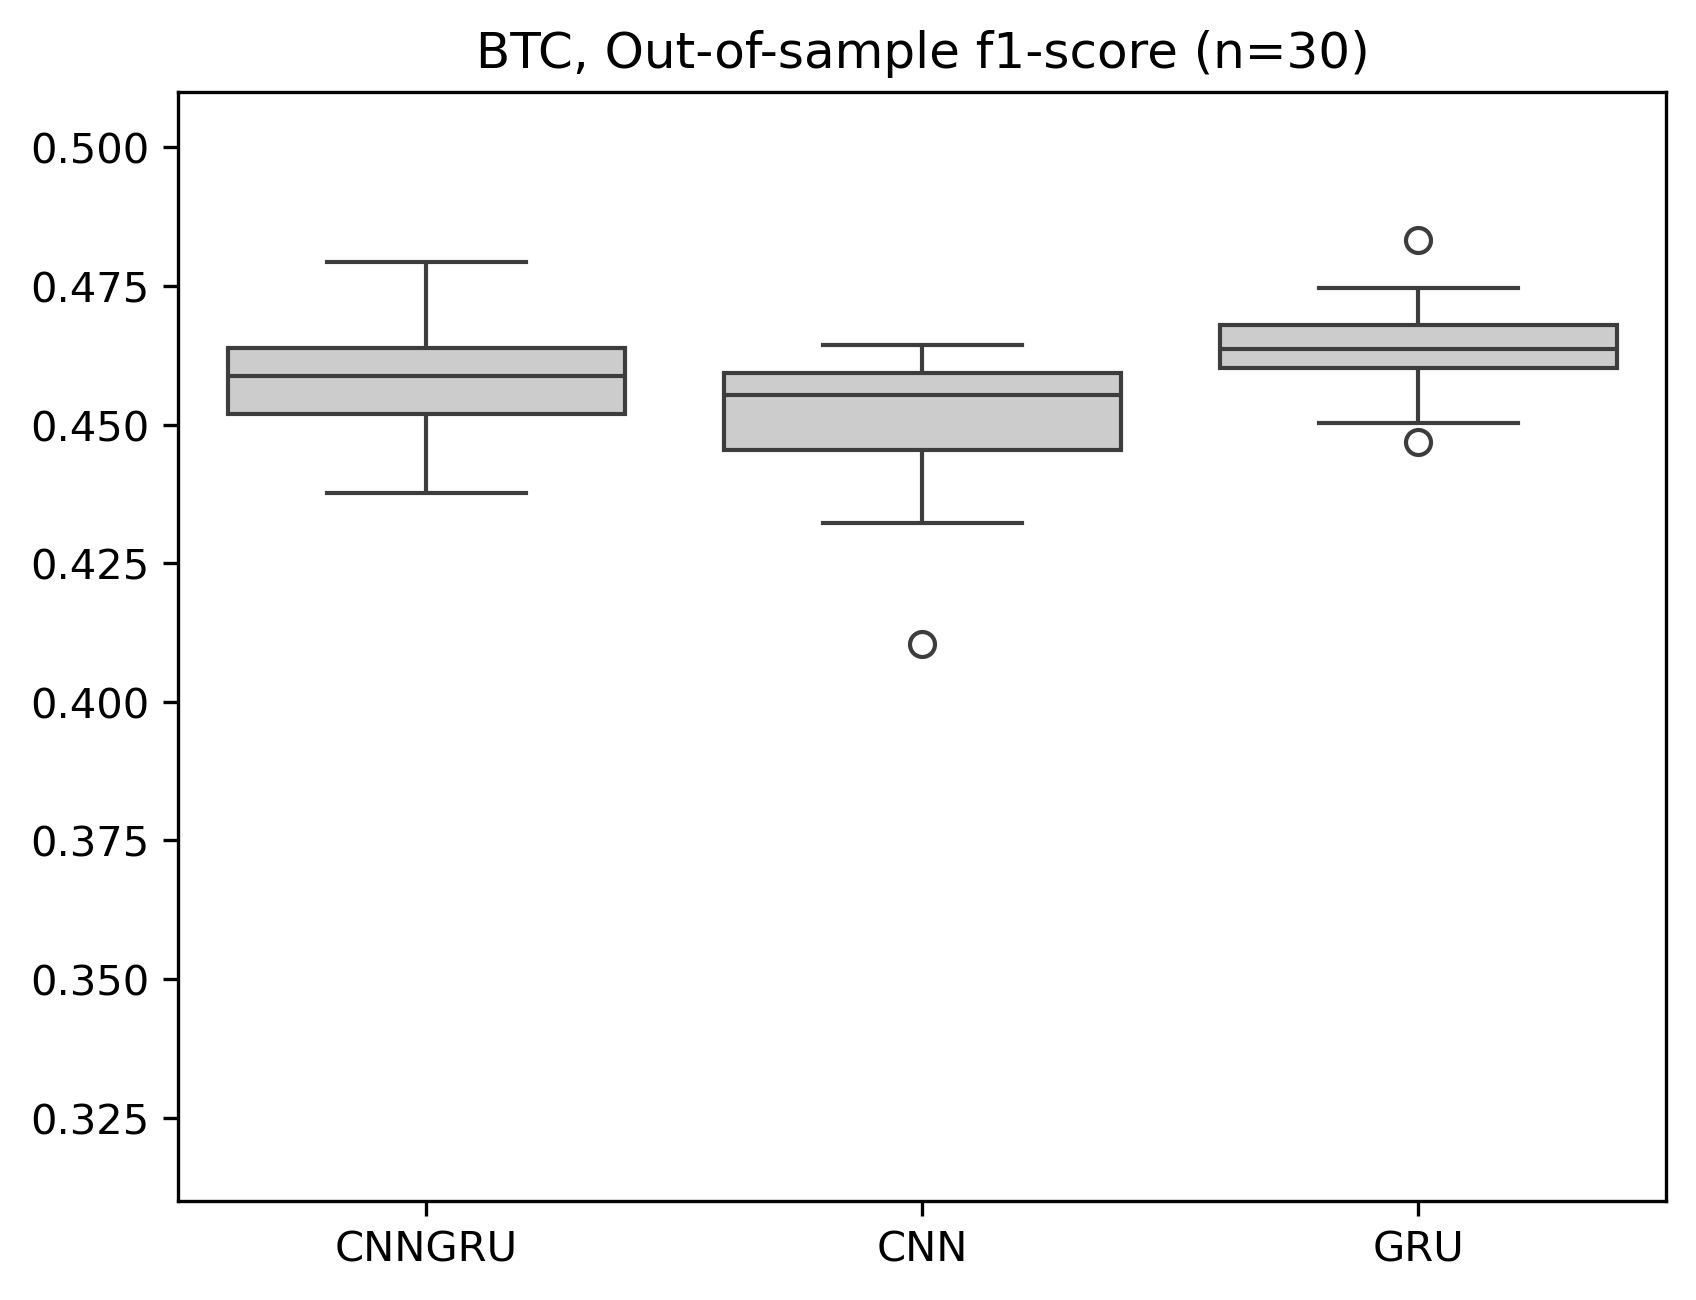

In [68]:
plt.figure(dpi=300)
sns.boxplot(btc_df_f1_score, color=".8")
plt.ylim(0.31, 0.51)
plt.title("BTC, Out-of-sample f1-score (n=30)")
plt.savefig("oos_f1_btc.png")
plt.show()

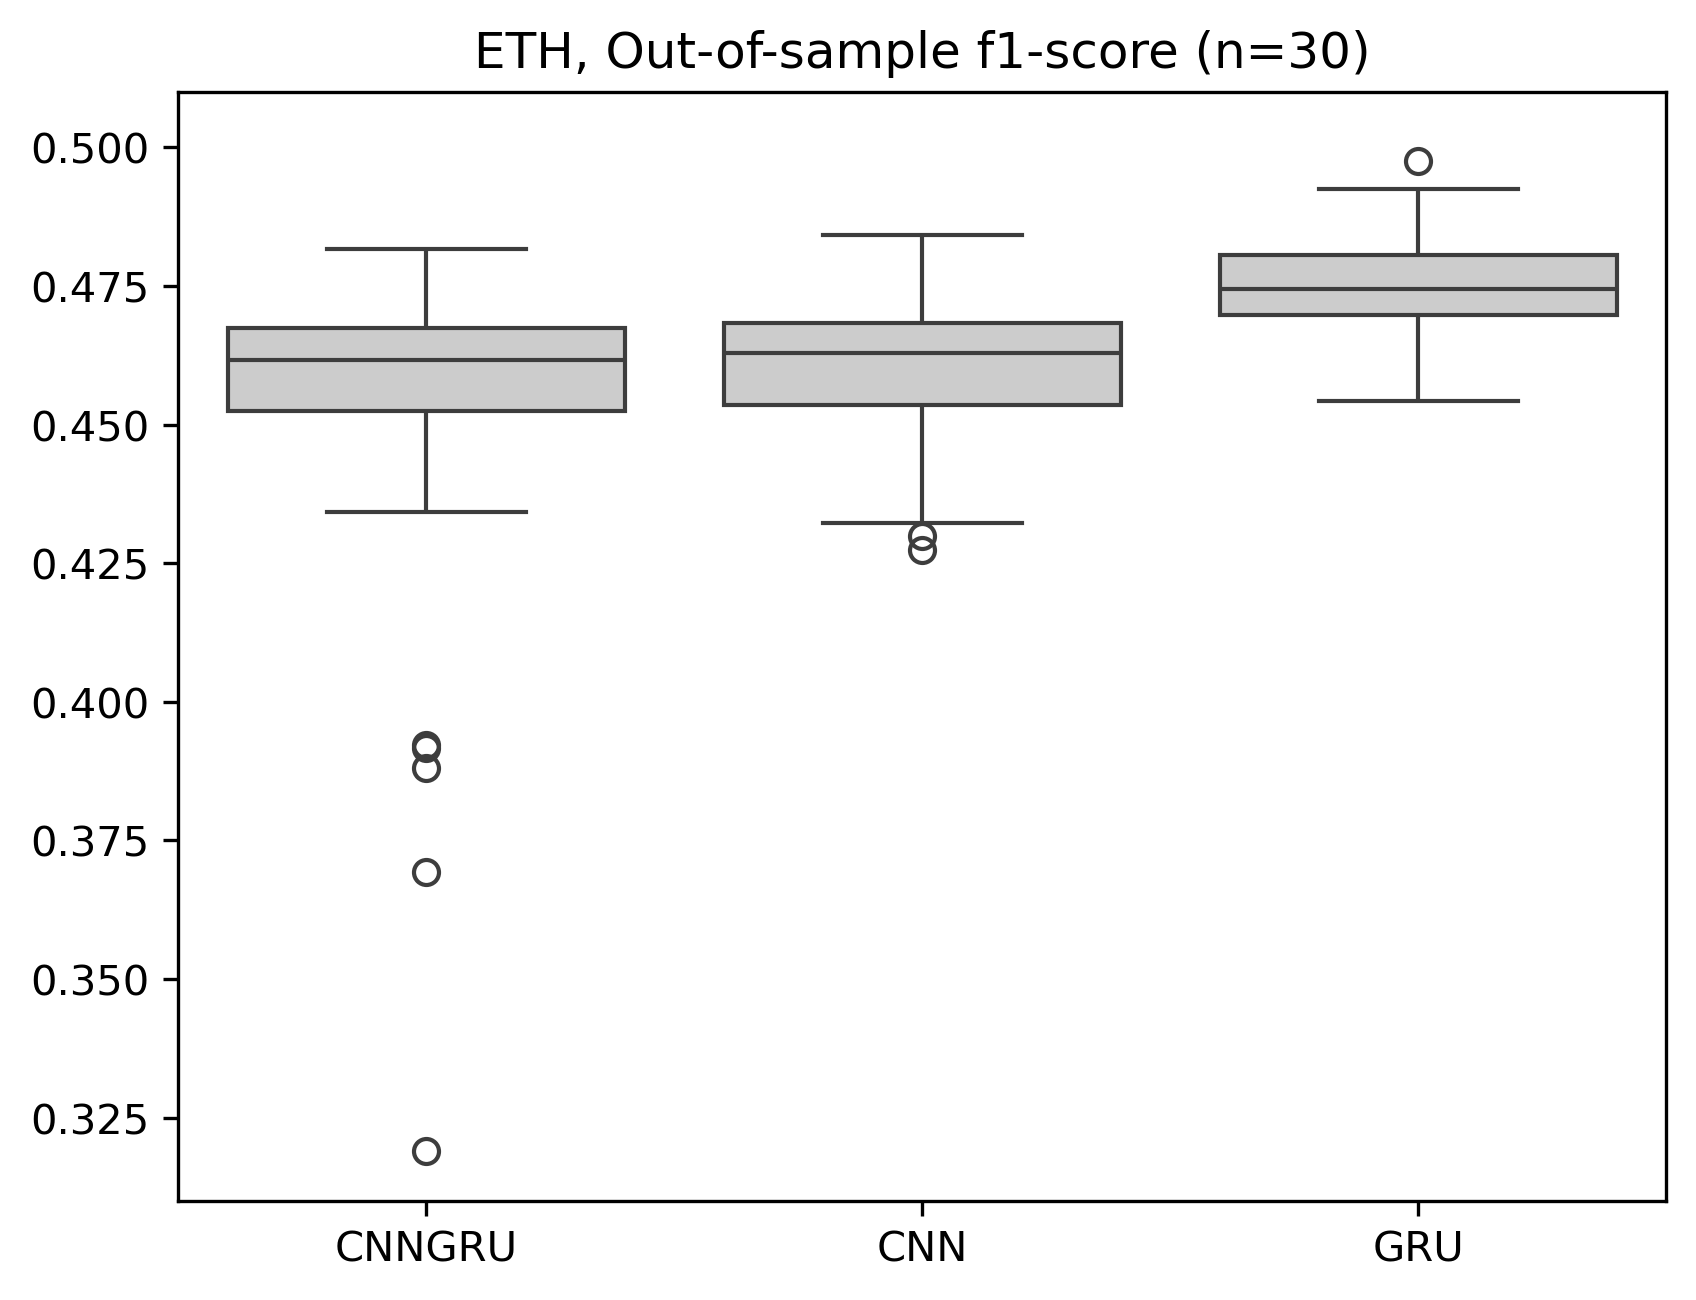

In [67]:
plt.figure(dpi=300)
sns.boxplot(eth_df_f1_score, color=".8")
plt.ylim(0.31, 0.51)
plt.title("ETH, Out-of-sample f1-score (n=30)")
plt.savefig("oos_f1_eth.png")
plt.show()

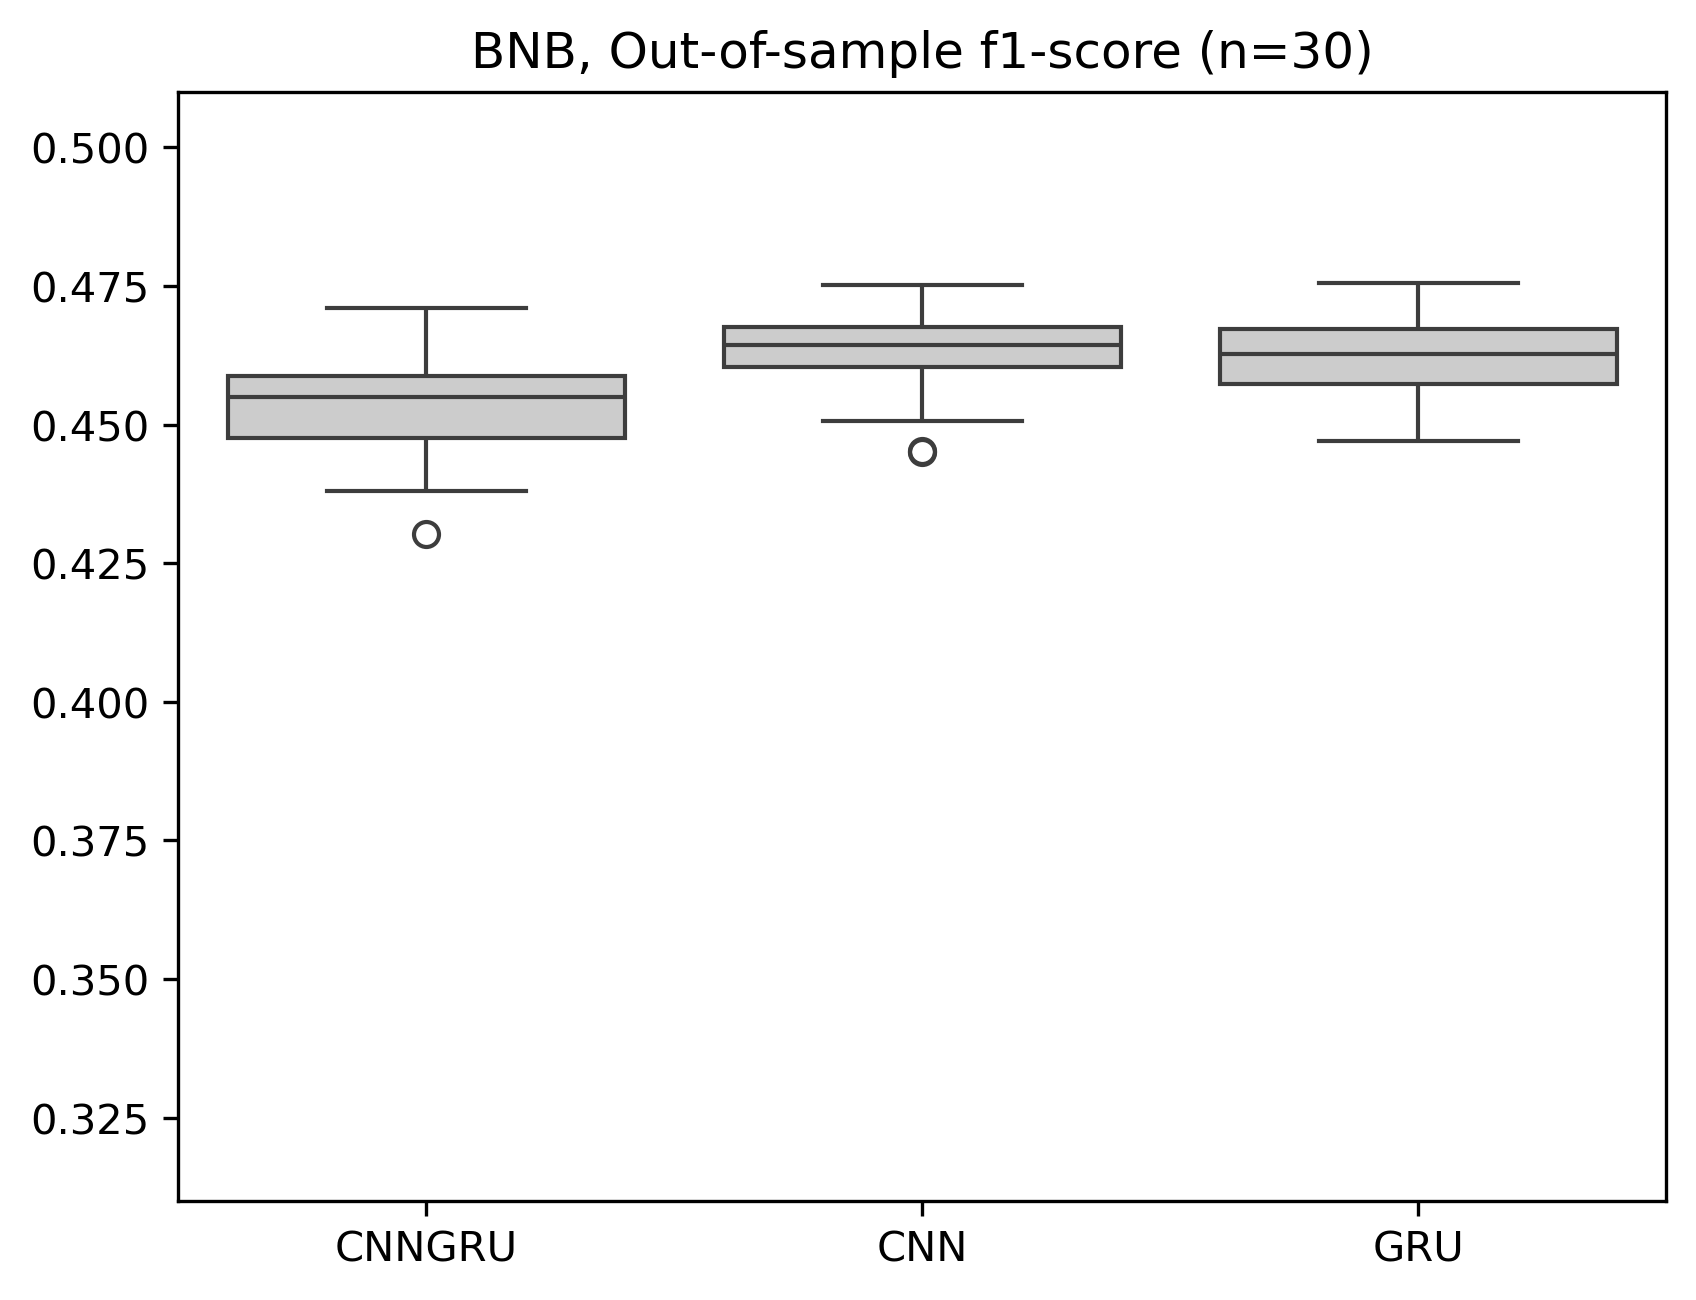

In [69]:
plt.figure(dpi=300)
sns.boxplot(bnb_df_f1_score, color=".8")
plt.ylim(0.31, 0.51)
plt.title("BNB, Out-of-sample f1-score (n=30)")
plt.savefig("oos_f1_bnb.png")
plt.show()

## Annualised returns

In [19]:
btc_df_annualised_returns = pd.DataFrame({"CNNGRU": BTC_CNNGRU_test_annualised_returns, "CNN": BTC_CNN_test_annualised_returns, "GRU": BTC_GRU_test_annualised_returns})

In [20]:
eth_df_annualised_returns = pd.DataFrame({"CNNGRU": ETH_CNNGRU_test_annualised_returns, "CNN": ETH_CNN_test_annualised_returns, "GRU": ETH_GRU_test_annualised_returns})

In [39]:
bnb_df_annualised_returns = pd.DataFrame({"CNNGRU": BNB_CNNGRU_test_annualised_returns, "CNN": BNB_CNN_test_annualised_returns, "GRU": BNB_GRU_test_annualised_returns})

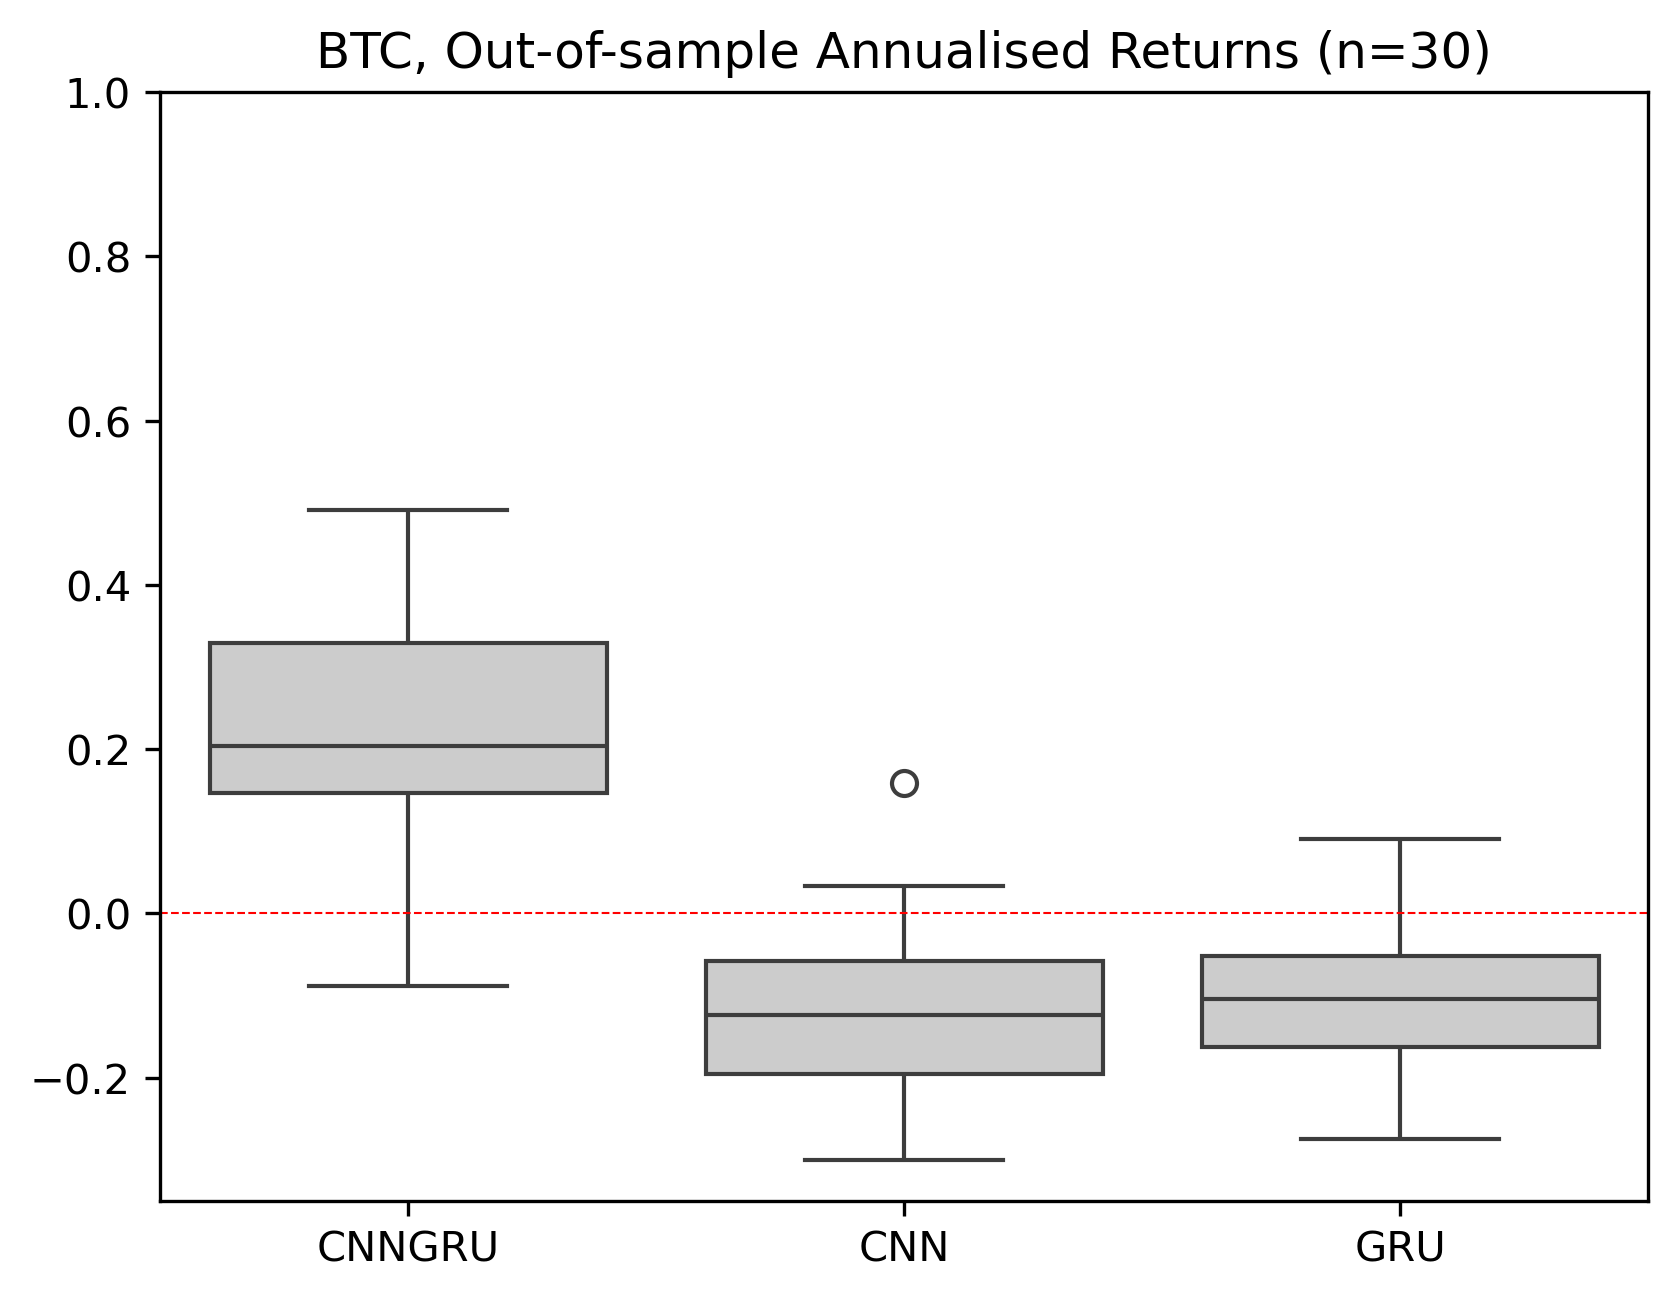

In [70]:
plt.figure(dpi=300)
sns.boxplot(btc_df_annualised_returns, color=".8")
plt.axhline(0, color="red", linewidth=0.5, linestyle="--")
plt.ylim(-0.35, 1.0)
plt.title("BTC, Out-of-sample Annualised Returns (n=30)")
plt.savefig("oos_annualised_returns_btc.png")
plt.show()

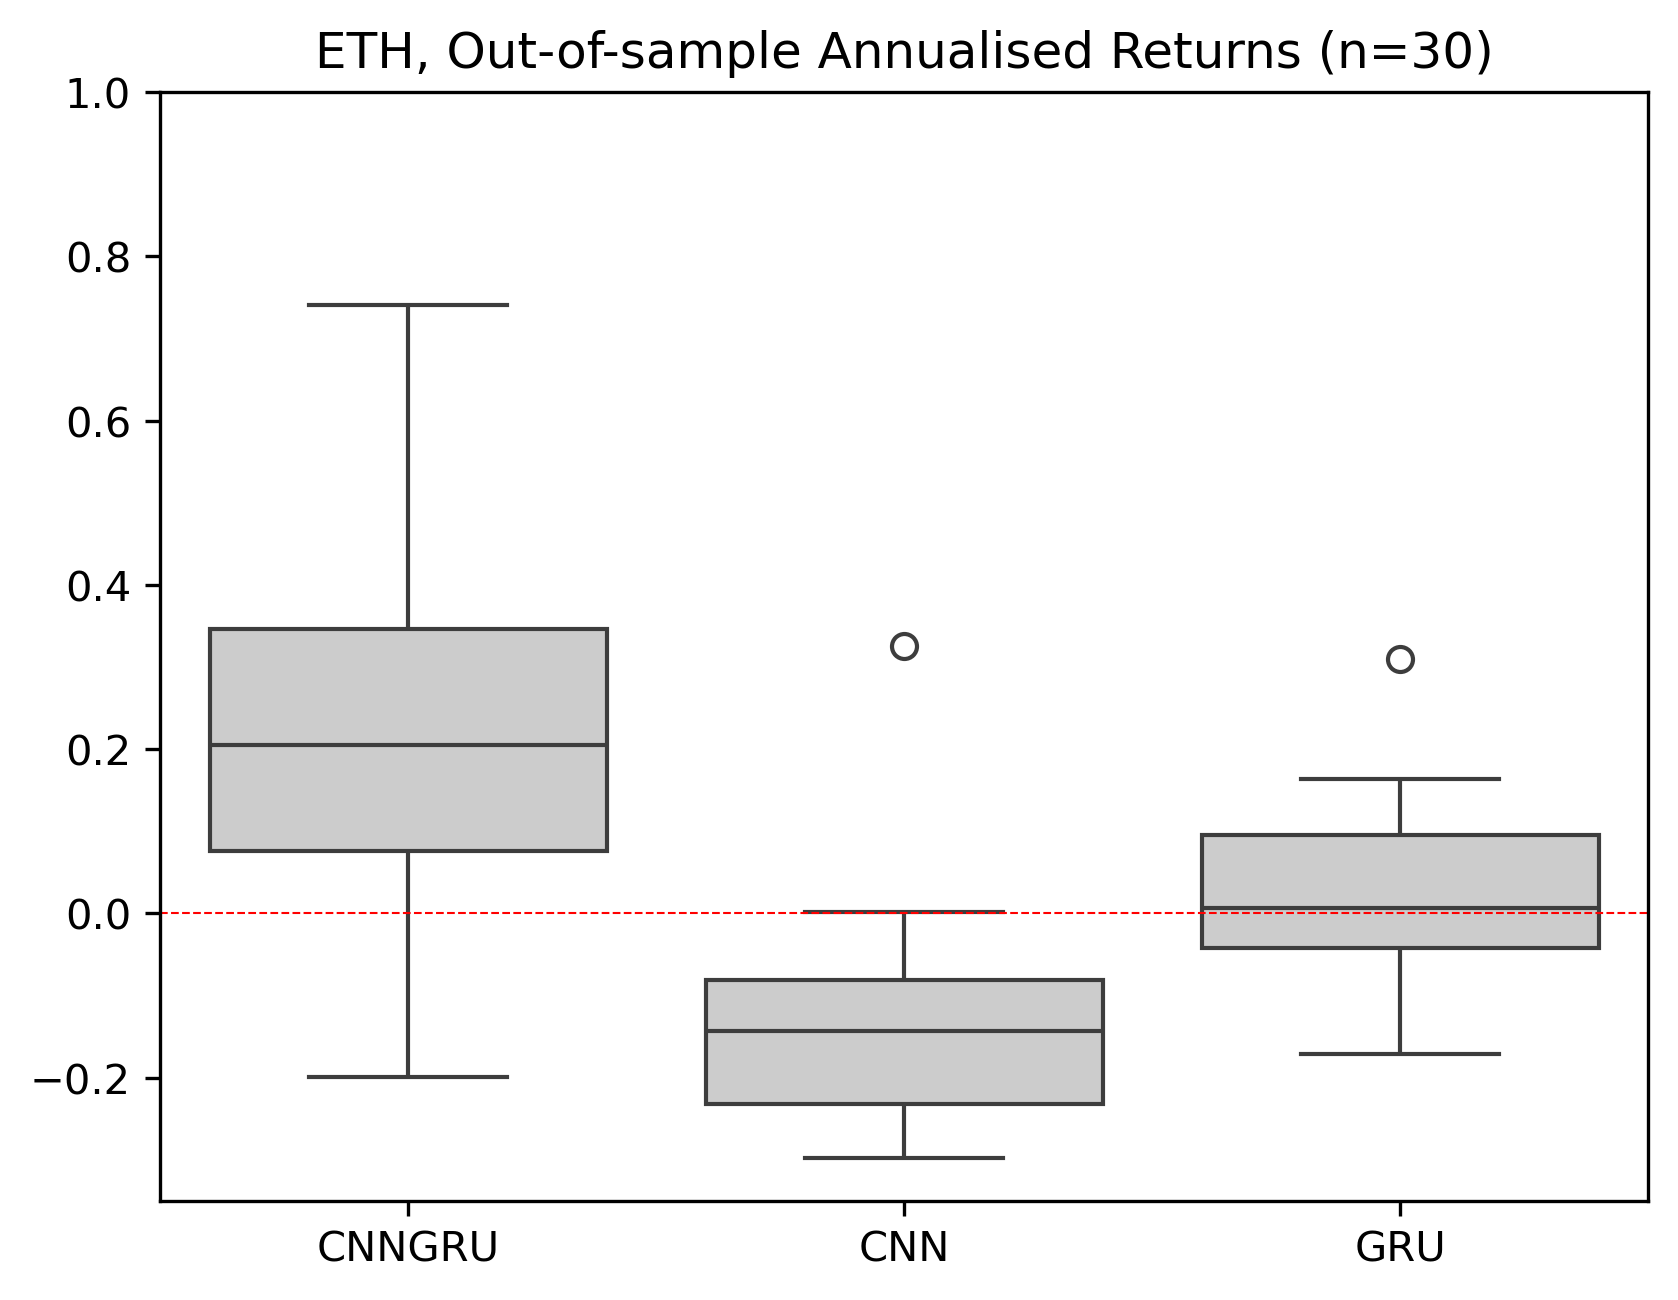

In [71]:
plt.figure(dpi=300)
sns.boxplot(eth_df_annualised_returns, color=".8")
plt.axhline(0, color="red", linewidth=0.5, linestyle="--")
plt.ylim(-0.35, 1.0)
plt.title("ETH, Out-of-sample Annualised Returns (n=30)")
plt.savefig("oos_annualised_returns_eth.png")
plt.show()

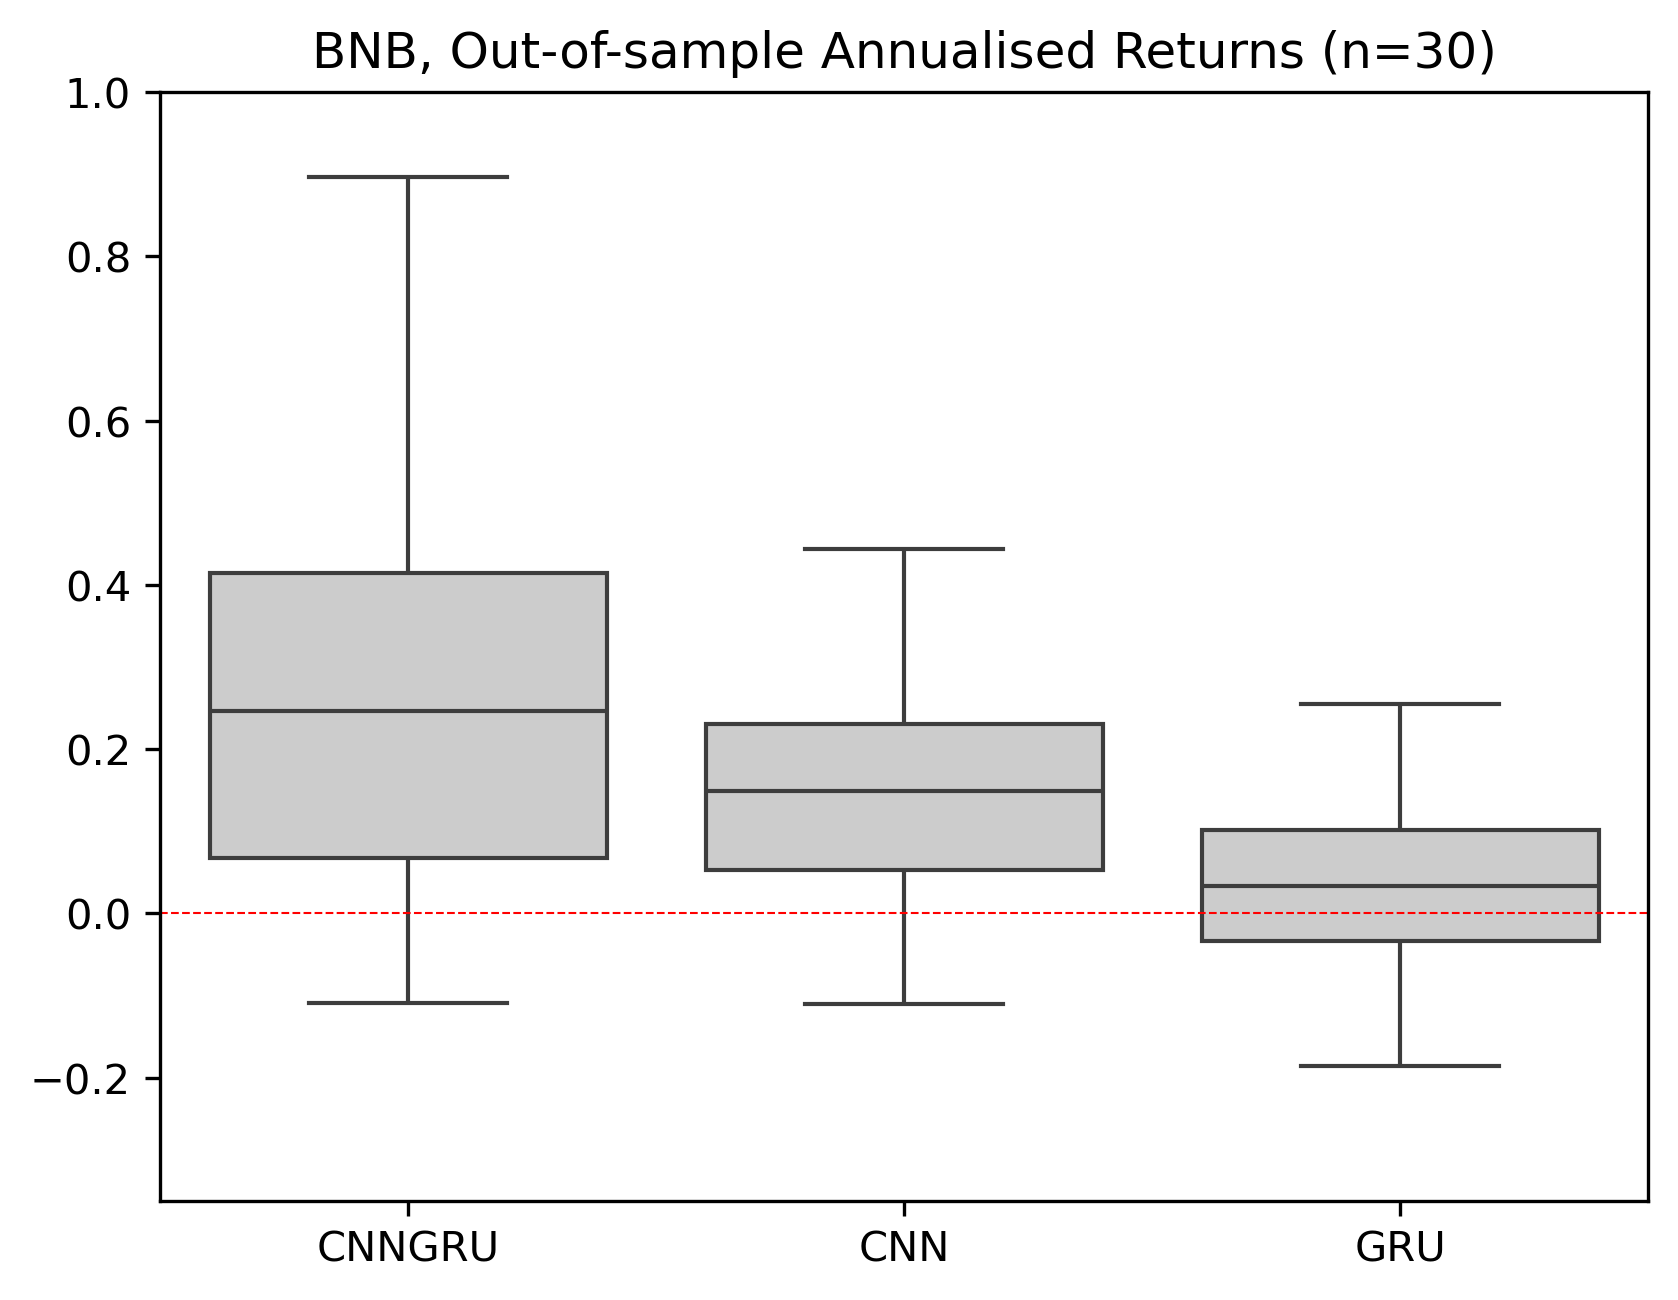

In [72]:
plt.figure(dpi=300)
sns.boxplot(bnb_df_annualised_returns, color=".8")
plt.axhline(0, color="red", linewidth=0.5, linestyle="--")
plt.ylim(-0.35, 1.0)
plt.title("BNB, Out-of-sample Annualised Returns (n=30)")
plt.savefig("oos_annualised_returns_bnb.png")
plt.show()

# Median Models

In [23]:
def get_median_model_index(score_list:list):
    """
    Get the index of the median performing model. In case the
    list length is even, get the upper median index.
    """
    list_len = len(score_list)
    return score_list.index(sorted(score_list)[list_len//2])

## BTC, CNN-GRU

In [28]:
get_median_model_index(BTC_CNNGRU_test_f1_score)

10

In [33]:
BTC_CNNGRU_exec = ExecutionHandler(dataset=btc, model=CNNGRU,
                                   model_id=f"BTC",
                                   device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, 
                                   test_end_idx=len(btc),
                                   checkpoints_path='./checkpoints-report-20240525',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
# BTC_CNNGRU_exec.model_trainer.test()
# BTC_CNNGRU_exec.execute_testing()

In [34]:
BTC_CNNGRU_exec.model.load_state_dict(torch.load("./checkpoints-report-20240525/CNNGRU-BTC-ITER10_EP20.pt"))

RuntimeError: Error(s) in loading state_dict for CNNGRU:
	size mismatch for stacked_gru_batchnorm.0.weight: copying a param with shape torch.Size([23]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for stacked_gru_batchnorm.0.bias: copying a param with shape torch.Size([23]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for stacked_gru_batchnorm.0.running_mean: copying a param with shape torch.Size([23]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for stacked_gru_batchnorm.0.running_var: copying a param with shape torch.Size([23]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([200, 1840]) from checkpoint, the shape in current model is torch.Size([200, 1600]).

In [30]:
BTC_CNNGRU_test_df = generate_preds(BTC_CNNGRU_exec.loader_gen.test_df, "CNNGRU",
                                 BTC_CNNGRU_exec.model_trainer.test_pred_y.numpy())

NameError: name 'generate_preds' is not defined

## BTC, CNN

In [97]:
get_median_model_index(BTC_CNN_test_f1_score)

20

In [ ]:
BTC_CNN_exec = ExecutionHandler(dataset=btc, model=CNN,
                                model_id=f"BTC",
                                device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                train_start_idx=0, 
                                test_end_idx=len(btc),
                                checkpoints_path='./checkpoints-profit-test',
                                preload_weights_path=None,
                                transform1=to_tensor, transform2=normalise,
                                transform3=reshape_tsr)
BTC_CNN_exec.execute_training_validation()
BTC_CNN_exec.execute_testing()

In [ ]:
BTC_CNN_test_df = generate_preds(BTC_CNN_exec.loader_gen.test_df, "CNN",
                                 BTC_CNN_exec.model_trainer.test_pred_y.numpy())

## BTC, GRU

In [ ]:
get_median_model_index(BTC_GRU_test_f1_score)

In [ ]:
BTC_GRU_exec = ExecutionHandler(dataset=btc, model=GRU,
                                model_id=f"BTC",
                                device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                train_start_idx=0, 
                                test_end_idx=len(btc),
                                checkpoints_path='./checkpoints-profit-test',
                                preload_weights_path=None,
                                transform1=to_tensor, transform2=normalise,
                                transform3=reshape_tsr)
BTC_GRU_exec.execute_training_validation()
BTC_GRU_exec.execute_testing()

In [ ]:
BTC_GRU_test_df = generate_preds(BTC_GRU_exec.loader_gen.test_df, "GRU",
                                 BTC_GRU_exec.model_trainer.test_pred_y.numpy())

## ETH, CNN-GRU

In [ ]:
ETH_CNNGRU_exec = ExecutionHandler(dataset=eth, model=CNNGRU,
                                   model_id=f"ETH",
                                   device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, 
                                   test_end_idx=len(eth),
                                   checkpoints_path='./checkpoints-profit-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
ETH_CNNGRU_exec.execute_training_validation()
ETH_CNNGRU_exec.execute_testing()

In [ ]:
ETH_CNNGRU_test_df = generate_preds(ETH_CNNGRU_exec.loader_gen.test_df, "CNNGRU",
                                    ETH_CNNGRU_exec.model_trainer.test_pred_y.numpy())

## ETH, CNN

In [ ]:
ETH_CNN_exec = ExecutionHandler(dataset=eth, model=CNN,
                                model_id=f"ETH",
                                device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                train_start_idx=0, 
                                test_end_idx=len(eth),
                                checkpoints_path='./checkpoints-profit-test',
                                preload_weights_path=None,
                                transform1=to_tensor, transform2=normalise,
                                transform3=reshape_tsr)
ETH_CNN_exec.execute_training_validation()
ETH_CNN_exec.execute_testing()

In [ ]:
ETH_CNN_test_df = generate_preds(ETH_CNN_exec.loader_gen.test_df, "CNN",
                                 ETH_CNN_exec.model_trainer.test_pred_y.numpy())

## ETH, GRU

In [ ]:
ETH_GRU_exec = ExecutionHandler(dataset=eth, model=GRU,
                                model_id=f"ETH",
                                device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                train_start_idx=0, 
                                test_end_idx=len(eth),
                                checkpoints_path='./checkpoints-profit-test',
                                preload_weights_path=None,
                                transform1=to_tensor, transform2=normalise,
                                transform3=reshape_tsr)
ETH_GRU_exec.execute_training_validation()
ETH_GRU_exec.execute_testing()

In [ ]:
ETH_GRU_test_df = generate_preds(ETH_GRU_exec.loader_gen.test_df, "GRU",
                                 ETH_GRU_exec.model_trainer.test_pred_y.numpy())

## BNB, CNN-GRU

In [ ]:
BNB_CNNGRU_exec = ExecutionHandler(dataset=bnb, model=CNNGRU,
                                   model_id=f"BNB",
                                   device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                   timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                   train_start_idx=0, 
                                   test_end_idx=len(bnb),
                                   checkpoints_path='./checkpoints-profit-test',
                                   preload_weights_path=None,
                                   transform1=to_tensor, transform2=normalise,
                                   transform3=reshape_tsr)
BNB_CNNGRU_exec.execute_training_validation()
BNB_CNNGRU_exec.execute_testing()

In [ ]:
BNB_CNNGRU_test_df = generate_preds(BNB_CNNGRU_exec.loader_gen.test_df, "CNNGRU",
                                    BNB_CNNGRU_exec.model_trainer.test_pred_y.numpy())

## BNB, CNN

In [ ]:
BNB_CNN_exec = ExecutionHandler(dataset=bnb, model=CNN,
                                model_id=f"BNB",
                                device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                train_start_idx=0, 
                                test_end_idx=len(bnb),
                                checkpoints_path='./checkpoints-profit-test',
                                preload_weights_path=None,
                                transform1=to_tensor, transform2=normalise,
                                transform3=reshape_tsr)
BNB_CNN_exec.execute_training_validation()
BNB_CNN_exec.execute_testing()

In [ ]:
BNB_CNN_test_df = generate_preds(BNB_CNN_exec.loader_gen.test_df, "CNN",
                                 BNB_CNN_exec.model_trainer.test_pred_y.numpy())

## BNB, GRU

In [ ]:
BNB_GRU_exec = ExecutionHandler(dataset=bnb, model=GRU,
                                model_id=f"BNB",
                                device=DEVICE, batch_size=BATCH_SIZE, lr=LR, 
                                timeperiod=TIMEPERIOD, random_state=RANDOM_SEED,
                                train_start_idx=0, 
                                test_end_idx=len(bnb),
                                checkpoints_path='./checkpoints-profit-test',
                                preload_weights_path=None,
                                transform1=to_tensor, transform2=normalise,
                                transform3=reshape_tsr)
BNB_GRU_exec.execute_training_validation()
BNB_GRU_exec.execute_testing()

In [ ]:
BNB_GRU_test_df = generate_preds(BNB_GRU_exec.loader_gen.test_df, "GRU",
                                 BNB_GRU_exec.model_trainer.test_pred_y.numpy())

# Profitability analysis

In [ ]:
class Stoploss:
    def __init__(self, stoploss=0.1):
        self.stoploss = stoploss
        self.price_open = None
        self.highest_stop_price = None
    
    def get_stop_price(self, price_open, price_curr, trailing=False):
        """
        Gets the stop price at the current iteration. The stop price 
        only ever moves up.
        """
        # Update the open price
        self.price_open = price_open
        # Update the highest stop price if None
        if not self.highest_stop_price:
            self.highest_stop_price = price_open * (1 - self.stoploss)
        if trailing:
            if price_curr > price_open:
                stop_price = price_curr * (1 - self.stoploss)
                if stop_price > self.highest_stop_price:
                    self.highest_stop_price = stop_price
            return self.highest_stop_price
        return self.highest_stop_price
    
    def reset(self):
        """
        Resets the state of the stoploss when an order is closed.
        """
        self.price_open = None
        self.highest_stop_price = None
        

In [ ]:
class SimulatedTradingSession:
    def __init__(self, df:pd.DataFrame, model_name: str, ticker: str, 
                 starting_capital:float=10000.0, 
                 fee_size:float=0.001, stake_size:float=1.0,
                 stoploss:float=0.05, trailing_stop=False,
                 signal="signal_pred"):
        self.df = df.copy()
        self.model_name = model_name
        self.ticker = ticker
        self.starting_balance = starting_capital
        self.current_balance = starting_capital
        self.capital = starting_capital
        self.fee_size = fee_size
        self.stake_size = stake_size
        self.signal = signal
        self.trailing_stop = trailing_stop
        self.in_market = False
        self.current_coin_quantity = 0.0
        self.order_history = {}
        self.df[f"balance_cumulative_{self.model_name}"] = starting_capital
        self.sl = Stoploss(stoploss=stoploss)
        
    def backtest(self, print_on_close=False):
        """
        Backtest assumes that the model will buy at a fixed
        stake according to the stake size, then sell everything.
        """
        print(f"Starting backtest on {self.ticker}...")
        print(f"Opening balance: {self.capital:.2f}")
        starting_idx = self.df.index[0]
        ending_idx = self.df.index[-1]
        for i in range(starting_idx+1, ending_idx+1):
            # ===============================================================
            # NOT IN THE MARKET
            if not self.in_market and self.df.loc[i-1][f"{self.signal}_{self.model_name}"] == 1:
                # Execute open long
                price_open = self.df.loc[i]['open']
                date_open = self.df.loc[i]['date']
                quantity_open_post_fee, trading_fee_open = self._execute_open(price_open=price_open)
                # Append stats to order history
                self._create_order_entry(date_open=date_open, 
                                         quantity_open=quantity_open_post_fee, 
                                         price_open=price_open, 
                                         trading_fee_open=trading_fee_open)
            
            # ===============================================================
            # IN THE MARKET
            elif self.in_market:
                # Get the currently open order
                orderid_open = len(self.order_history)
                order_open = self.order_history[orderid_open]
                # Get its open price
                price_open = order_open['price_open']
                # The current price is the close price of previous timestep
                price_curr = self.df.loc[i-1]['close']
                stop_price = self.sl.get_stop_price(price_open, 
                                                    price_curr, 
                                                    trailing=self.trailing_stop)
                # If sell signal, or current price is lower than stop price, close the order
                if (self.df.loc[i-1][f"{self.signal}_{self.model_name}"] == 2) or \
                (price_curr <= stop_price):
                    # Execute close long
                    date_close = self.df.loc[i]['date']
                    quantity_close, trading_fee_close = self._execute_close(
                        price_close=price_curr
                    )
                    # Append new stats to the current order
                    self._update_closed_order(date_close=date_close, 
                                              quantity_close=quantity_close, 
                                              price_close=price_curr, 
                                              trading_fee_close=trading_fee_close)
                    # Print stats on close
                    if print_on_close:
                        self._print_stats()
                    # Reset the stoploss object
                    self.sl.reset()
            # Update current balance
            self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
            # Update the cumulative balance
            self.df.loc[i, f"balance_cumulative_{self.model_name}"] = self.current_balance
        # Report final value:
        print("==========================================================")
        print(f"Backtest finished.\nClosing balance: {self.current_balance:.2f}, PNL: {self.current_balance-self.starting_balance:.2f}")
        if self.in_market:
            last_orderid = len(self.order_history)
            print(f"Open order: {self.order_history[last_orderid]}")
            
    def _execute_open(self, price_open):
        # Declare the $ stake at the current step, ready to open
        stake_open = self.stake_size * self.capital
        # Calculate the fee for this buy trade
        trading_fee_open = self.fee_size * stake_open
        # Calculate the post-fee stake for each trade
        stake_open_post_fee = stake_open - trading_fee_open
        # Calculate the quantity that will be purchased for the post-fee stake
        quantity_open_post_fee = stake_open_post_fee / price_open
        # TRANSACTION COMPLETE: Update the current capital buy subtracting the total stake
        self.capital -= stake_open
        # TRANSACTION COMPLETE: Update the current quantity
        self.current_coin_quantity += quantity_open_post_fee
        # The model is now in the market
        self.in_market = True
        # Report new account balance
        self.current_balance = self.capital + self.current_coin_quantity * price_open
        # Return the post-fee quantity open and open fee
        return quantity_open_post_fee, trading_fee_open
    
    def _execute_close(self, price_close):
        # Declare the $ stake at the current step, ready to sell
        quantity_close = self.current_coin_quantity
        stake_close = quantity_close * price_close
        # Calculate the fee for this sell trade
        trading_fee_close = self.fee_size * stake_close
        # TRANSACTION COMPLETE: Add back the capital minus trading fee
        self.capital += (stake_close - trading_fee_close)
        # TRANSACTION COMPLETE: Update the current quantity
        self.current_coin_quantity -= quantity_close
        # The model is now out of the market
        self.in_market = False
        # Update current balance
        self.current_balance = self.capital + self.current_coin_quantity * price_close
        # Return the post-fee quantity close and close fee
        return quantity_close, trading_fee_close
    
    def _create_order_entry(self, date_open, quantity_open, price_open, trading_fee_open):
        # Append stats to order history
        self.order_history[len(self.order_history)+1] = {
            'ticker': self.ticker,
            'date_open': date_open,
            'quantity_open': quantity_open,
            'price_open': price_open,
            'date_close': None,
            'quantity_close': None,
            'price_close': None,
            'fee_open': trading_fee_open,
            'fee_close': None,
            'fee_total': trading_fee_open,
            'closed': False,
            'pnl': None
        }
    
    def _update_closed_order(self, date_close, quantity_close, price_close, trading_fee_close):
        orderid = len(self.order_history)
        self.order_history[orderid]['closed'] = True
        self.order_history[orderid]['date_close'] = date_close
        self.order_history[orderid]['quantity_close'] = quantity_close
        self.order_history[orderid]['price_close'] = price_close
        self.order_history[orderid]['fee_close'] = trading_fee_close
        self.order_history[orderid]['fee_total'] += trading_fee_close
        self.order_history[orderid]['pnl'] = \
            (self.order_history[orderid]['price_close'] * self.order_history[orderid]['quantity_close']) - \
            (self.order_history[orderid]['price_open'] * self.order_history[orderid]['quantity_open']) - \
            self.order_history[orderid]['fee_total']
    
    def _print_stats(self):
        orderid = len(self.order_history)
        if self.order_history[orderid]['closed']:
            print(f"#{orderid}-{self.ticker}: OPEN {self.order_history[orderid]['quantity_open']:.4f} @ {self.order_history[orderid]['price_open']:.2f}\t\
CLOSE {self.order_history[orderid]['quantity_close']:.4f} @ {self.order_history[orderid]['price_close']:.2f}\t\
FEE: {self.order_history[orderid]['fee_total']:.2f}\t\
PNL: {self.order_history[orderid]['pnl']:.2f}\t\
BALANCE: {self.current_balance:.2f}")
    
    
    def get_cumulative_returns(self):
        portfolio_returns = self.df[f"balance_cumulative_{self.model_name}"].pct_change()[1:]
        self.df[f"{self.model_name}"] = np.cumprod(portfolio_returns + 1)
        return
        

In [ ]:
# class SimulatedTradingSession:
#     def __init__(self, df:pd.DataFrame, model_name: str, ticker: str, 
#                  starting_capital:float=10000.0, 
#                  fee_size:float=0.001, stake_size:float=1.0,
#                  signal="signal_pred"):
#         self.df = df.copy()
#         self.model_name = model_name
#         self.ticker = ticker
#         self.starting_balance = starting_capital
#         self.current_balance = starting_capital
#         self.capital = starting_capital
#         self.fee_size = fee_size
#         self.stake_size = stake_size
#         self.signal = signal
#         self.in_market = False
#         self.current_coin_quantity = 0.00000000
#         self.order_history = {}
#         self.df[f"balance_cumulative_{self.model_name}"] = starting_capital
        
#     def backtest(self):
#         """
#         Backtest assumes that the model will buy at a fixed
#         stake according to the stake size, then sell everything.
#         """
#         print(f"Starting backtest on {self.ticker}...")
#         print(f"Opening balance: {self.capital:.2f}")
#         starting_idx = self.df.index[0]
#         ending_idx = self.df.index[-1]
#         for i in range(starting_idx+1, ending_idx+1):
#             if not self.in_market and self.df.loc[i-1][f"{self.signal}_{self.model_name}"] == 1:
#                 # Declare the $ stake at the current step, ready to buy
#                 stake_buy = self.stake_size * self.capital
#                 # Calculate the fee for this buy trade
#                 trading_fee_buy = self.fee_size * stake_buy
#                 # Calculate the post-fee stake for each trade
#                 stake_buy_post_fee = stake_buy - trading_fee_buy
#                 # Calculate the quantity that will be purchased for the post-fee stake
#                 quantity_buy_post_fee = stake_buy_post_fee / self.df.loc[i-1]['close']
#                 # TRANSACTION COMPLETE: Update the current capital buy subtracting the total stake
#                 self.capital -= stake_buy
#                 # TRANSACTION COMPLETE: Update the current quantity
#                 self.current_coin_quantity += quantity_buy_post_fee
#                 # The model is now in the market
#                 self.in_market = True
#                 # Report new account balance
#                 self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
#                 # Append stats to order history
#                 self.order_history[len(self.order_history)+1] = {
#                     'ticker': self.ticker,
#                     'date_open': self.df.loc[i]['date'],
#                     'quantity_open': round(quantity_buy_post_fee, 8),
#                     'price_open': round(self.df.loc[i-1]['close'], 2),
#                     'date_close': None,
#                     'quantity_close': None,
#                     'price_close': None,
#                     'fee_open': round(trading_fee_buy, 2),
#                     'fee_close': None,
#                     'fee_total': round(trading_fee_buy, 2),
#                     'closed': False,
#                     'pnl': None
#                 }
#                 # Print stats: 
# #                 print(f"ENTER:\t{self.current_coin_quantity:.8f} {self.ticker} @ {self.df.loc[i-1]['close']:.2f}\tFEE: {-trading_fee_buy:.2f}\tBALANCE: {self.current_balance:.2f}")
            
#             elif self.in_market and self.df.loc[i-1][f"{self.signal}_{self.model_name}"] == 2:
#                 # Declare the $ stake at the current step, ready to sell
#                 quantity_sell = self.current_coin_quantity
#                 stake_sell = quantity_sell * self.df.loc[i-1]['close']
#                 # Calculate the fee for this sell trade
#                 trading_fee_sell = self.fee_size * stake_sell
#                 # TRANSACTION COMPLETE: Add back the capital minus trading fee
#                 self.capital += (stake_sell - trading_fee_sell)
#                 # TRANSACTION COMPLETE: Update the current quantity
#                 self.current_coin_quantity -= quantity_sell
#                 # The model is now out of the market
#                 self.in_market = False
#                 # Update current balance
#                 self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
#                 # Append new stats to the current order
#                 orderid = len(self.order_history)
#                 self.order_history[orderid]['closed'] = True
#                 self.order_history[orderid]['date_close'] = self.df.loc[i]['date']
#                 self.order_history[orderid]['quantity_close'] = quantity_sell
#                 self.order_history[orderid]['price_close'] = round(self.df.loc[i-1]['close'], 2)
#                 self.order_history[orderid]['fee_close'] = trading_fee_sell
#                 self.order_history[orderid]['fee_total'] += self.order_history[orderid]['fee_close']
#                 self.order_history[orderid]['pnl'] = \
#                     (self.order_history[orderid]['price_close'] * self.order_history[orderid]['quantity_close']) - \
#                     (self.order_history[orderid]['price_open'] * self.order_history[orderid]['quantity_open']) - \
#                     self.order_history[orderid]['fee_total']
                
#                 # Print stats: 
# #                 print(f"EXIT:\t{quantity_sell:.8f} {self.ticker} @ {self.df.loc[i-1]['close']:.2f}\tFEE: {-trading_fee_sell:.2f}\tBALANCE: {self.current_balance:.2f}\tPNL: {self.order_history[orderid]['pnl']:.2f}")
#             # Update current balance
#             self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
#             # Update the cumulative balance
#             self.df.loc[i, f"balance_cumulative_{self.model_name}"] = self.current_balance
#         # Report final value:
#         print("==========================================================")
#         print(f"Backtest finished.\nClosing balance: {self.current_balance:.2f}, PNL: {self.current_balance-self.starting_balance:.2f}")
#         if self.in_market:
#             last_orderid = len(self.order_history)
#             print(f"Open order: {self.order_history[last_orderid]}")
            
#     def get_cumulative_returns(self):
#         portfolio_returns = self.df[f"balance_cumulative_{self.model_name}"].pct_change()[1:]
#         self.df[f"{self.model_name}"] = np.cumprod(portfolio_returns + 1)
#         return
        

## Profitability: BTC dataset

In [ ]:
len(BTC_CNNGRU_exec.model_trainer.test_pred_y)

In [ ]:
BTC_test_df = generate_preds(df_test=BTC_CNNGRU_exec.loader_gen.test_df, 
                             model_name='CNNGRU',
                             test_preds=BTC_CNNGRU_exec.model_trainer.test_pred_y.numpy())

BTC_test_df = generate_preds(df_test=BTC_test_df, 
                             model_name='CNN',
                             test_preds=BTC_CNN_exec.model_trainer.test_pred_y.numpy())

BTC_test_df = generate_preds(df_test=BTC_test_df, 
                             model_name='GRU',
                             test_preds=BTC_GRU_exec.model_trainer.test_pred_y.numpy())

In [ ]:
BTC_simulator = SimulatedTradingSession(df=BTC_test_df, model_name="CNNGRU", 
                                        ticker="BTC", stake_size=1.0, 
                                        signal="signal_pred", stoploss=0.1, trailing_stop=True)
BTC_simulator.backtest()
BTC_simulator.get_cumulative_returns()

BTC_simulator = SimulatedTradingSession(df=BTC_simulator.df, model_name="CNN", 
                                        ticker="BTC", stake_size=1.0, 
                                        signal="signal_pred", stoploss=0.1, trailing_stop=True)
BTC_simulator.backtest()
BTC_simulator.get_cumulative_returns()

BTC_simulator = SimulatedTradingSession(df=BTC_simulator.df, model_name="GRU", 
                                        ticker="BTC", stake_size=1.0, 
                                        signal="signal_pred", stoploss=0.1, trailing_stop=True)
BTC_simulator.backtest()
BTC_simulator.get_cumulative_returns()


In [ ]:
BTC_cum_rets_df = BTC_simulator.df[["date", "CNNGRU", "CNN", "GRU"]]
BTC_cum_rets_df = BTC_cum_rets_df.melt("date", var_name='Model',  value_name='vals')

In [ ]:
sns.lineplot(data=BTC_cum_rets_df, 
             x="date", y="vals", hue="Model", palette="cubehelix")
plt.title("BTC, Cumulative Returns of Models")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cumulative returns")
plt.savefig("btc_cumrets.png", bbox_inches='tight')
plt.show()

## Profitability: ETH dataset

In [ ]:
ETH_test_df = generate_preds(df_test=ETH_CNNGRU_exec.loader_gen.test_df, 
                             model_name='CNNGRU',
                             test_preds=ETH_CNNGRU_exec.model_trainer.test_pred_y.numpy())

ETH_test_df = generate_preds(df_test=ETH_test_df, 
                             model_name='CNN',
                             test_preds=ETH_CNN_exec.model_trainer.test_pred_y.numpy())

ETH_test_df = generate_preds(df_test=ETH_test_df, 
                             model_name='GRU',
                             test_preds=ETH_GRU_exec.model_trainer.test_pred_y.numpy())

In [ ]:
ETH_simulator = SimulatedTradingSession(df=ETH_test_df, model_name="CNNGRU", 
                                        ticker="ETH", stake_size=1.0, 
                                        signal="signal_pred", stoploss=0.1, trailing_stop=True)
ETH_simulator.backtest()
ETH_simulator.get_cumulative_returns()

ETH_simulator = SimulatedTradingSession(df=ETH_simulator.df, model_name="CNN", 
                                        ticker="ETH", stake_size=1.0, 
                                        signal="signal_pred", stoploss=0.1, trailing_stop=True)
ETH_simulator.backtest()
ETH_simulator.get_cumulative_returns()

ETH_simulator = SimulatedTradingSession(df=ETH_simulator.df, model_name="GRU", 
                                        ticker="ETH", stake_size=1.0, 
                                        signal="signal_pred", stoploss=0.1, trailing_stop=True)
ETH_simulator.backtest()
ETH_simulator.get_cumulative_returns()


In [ ]:
ETH_simulator = SimulatedTradingSession(df=ETH_test_df, model_name="CNNGRU", 
                                        ticker="ETH", stake_size=1.0, 
                                        signal="signal_pred", stoploss=1, trailing_stop=True)
ETH_simulator.backtest()
ETH_simulator.get_cumulative_returns()

ETH_simulator = SimulatedTradingSession(df=ETH_simulator.df, model_name="CNN", 
                                        ticker="ETH", stake_size=1.0, 
                                        signal="signal_pred", stoploss=1, trailing_stop=True)
ETH_simulator.backtest()
ETH_simulator.get_cumulative_returns()

ETH_simulator = SimulatedTradingSession(df=ETH_simulator.df, model_name="GRU", 
                                        ticker="ETH", stake_size=1.0, 
                                        signal="signal_pred", stoploss=1, trailing_stop=True)
ETH_simulator.backtest()
ETH_simulator.get_cumulative_returns()


In [ ]:
ETH_cum_rets_df = ETH_simulator.df[["date", "CNNGRU", "CNN", "GRU"]]
ETH_cum_rets_df = ETH_cum_rets_df.melt("date", var_name='Model',  value_name='vals')

In [ ]:
sns.lineplot(data=ETH_cum_rets_df, 
             x="date", y="vals", hue="Model", palette="cubehelix")
plt.title("ETH, Cumulative Returns of Models")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cumulative returns")
plt.savefig("eth_cumrets.png", bbox_inches='tight')
plt.show()

## Profitability: BNB dataset

In [ ]:
BNB_test_df = generate_preds(df_test=BNB_CNNGRU_exec.loader_gen.test_df, 
                             model_name='CNNGRU',
                             test_preds=BNB_CNNGRU_exec.model_trainer.test_pred_y.numpy())

BNB_test_df = generate_preds(df_test=BNB_test_df, 
                             model_name='CNN',
                             test_preds=BNB_CNN_exec.model_trainer.test_pred_y.numpy())

BNB_test_df = generate_preds(df_test=BNB_test_df, 
                             model_name='GRU',
                             test_preds=BNB_GRU_exec.model_trainer.test_pred_y.numpy())

In [ ]:
BNB_simulator = SimulatedTradingSession(df=BNB_test_df, model_name="CNNGRU", ticker="BNB", stake_size=1.0, signal="signal_pred")
BNB_simulator.backtest()
BNB_simulator.get_cumulative_returns()

BNB_simulator = SimulatedTradingSession(df=BNB_simulator.df, model_name="CNN", ticker="BNB", stake_size=1.0, signal="signal_pred")
BNB_simulator.backtest()
BNB_simulator.get_cumulative_returns()

BNB_simulator = SimulatedTradingSession(df=BNB_simulator.df, model_name="GRU", ticker="BNB", stake_size=1.0, signal="signal_pred")
BNB_simulator.backtest()
BNB_simulator.get_cumulative_returns()


In [ ]:
BNB_cum_rets_df = BNB_simulator.df[["date", "CNNGRU", "CNN", "GRU"]]
BNB_cum_rets_df = BNB_cum_rets_df.melt("date", var_name='Model',  value_name='vals')

In [ ]:
sns.lineplot(data=BNB_cum_rets_df, 
             x="date", y="vals", hue="Model", palette="cubehelix")
plt.title("BNB, Cumulative Returns of Models")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cumulative returns")
plt.savefig("bnb_cumrets.png", bbox_inches='tight')
plt.show()

# Confusion matrices

In [ ]:
BTC_CNNGRU_exec.model_trainer.test_confusion_matrix

In [ ]:
BTC_CNN_exec.model_trainer.test_confusion_matrix

In [ ]:
BTC_GRU_exec.model_trainer.test_confusion_matrix

In [ ]:
ETH_CNNGRU_exec.model_trainer.test_confusion_matrix

In [ ]:
ETH_CNN_exec.model_trainer.test_confusion_matrix

In [ ]:
ETH_GRU_exec.model_trainer.test_confusion_matrix

In [ ]:
BNB_CNNGRU_exec.model_trainer.test_confusion_matrix

In [ ]:
BNB_CNN_exec.model_trainer.test_confusion_matrix

In [ ]:
BNB_GRU_exec.model_trainer.test_confusion_matrix

# Statistical significance

In [42]:
def paired_ttest(cnngru: list, other: list):
    test = ttest_rel(a=cnngru, b=other, alternative="greater")
    return test

In [96]:
paired_ttest(BNB_CNNGRU_test_annualised_returns, BNB_GRU_test_annualised_returns)

TtestResult(statistic=4.444205199180267, pvalue=5.922500123917313e-05, df=29)

In [ ]:
class SimulatedTradingSessionWithShorting:
    def __init__(self, df:pd.DataFrame, model_name: str, ticker: str, 
                 starting_capital:float=10000.0, 
                 fee_size:float=0.001, stake_size:float=1.0,
                 signal="signal_pred"):
        self.df = df.copy()
        self.model_name = model_name
        self.ticker = ticker
        self.starting_balance = starting_capital
        self.current_balance = starting_capital
        self.capital = starting_capital
        self.fee_size = fee_size
        self.stake_size = stake_size
        self.signal = signal
        self.in_market = False
        self.is_open_long = False
        self.is_open_short = False
        self.current_coin_quantity = 0.00000000
        self.order_history = {}
        self.df[f"balance_cumulative_{self.model_name}"] = starting_capital
        
    def backtest(self):
        """
        Backtest assumes that the model will buy at a fixed
        stake according to the stake size, then sell everything.
        """
        print(f"Starting backtest on {self.ticker}...")
        print(f"Opening balance: {self.capital:.2f}")
        starting_idx = self.df.index[0]
        ending_idx = self.df.index[-1]
        for i in range(starting_idx+1, ending_idx+1):
            # ================================================================================
            # LONG ENTRY
            if not self.in_market and self.df.loc[i-1][f"{self.signal}_{self.model_name}"] == 1:
                # Declare the $ stake at the current step, ready to buy
                stake_buy = self.stake_size * self.capital
                # Calculate the fee for this buy trade
                trading_fee_buy = self.fee_size * stake_buy
                # Calculate the post-fee stake for each trade
                stake_buy_post_fee = stake_buy - trading_fee_buy
                # Calculate the quantity that will be purchased for the post-fee stake
                quantity_buy_post_fee = stake_buy_post_fee / self.df.loc[i-1]['close']
                # TRANSACTION COMPLETE: Update the current capital buy subtracting the total stake
                self.capital -= stake_buy
                # TRANSACTION COMPLETE: Update the current quantity
                self.current_coin_quantity += quantity_buy_post_fee
                # The model is now in the market
                self.in_market = True
                # Report new account balance
                self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
                # Append stats to order history
                self.order_history[len(self.order_history)+1] = {
                    'ticker': self.ticker,
                    'date_open': self.df.loc[i]['date'],
                    'quantity_open': quantity_buy_post_fee,
                    'price_open': self.df.loc[i-1]['close'],
                    'order_type': 'long',
                    'date_close': None,
                    'quantity_close': None,
                    'price_close': None,
                    'fee_open': trading_fee_buy,
                    'fee_close': None,
                    'fee_total': trading_fee_buy,
                    'closed': False,
                    'pnl': None
                }
                # Print stats: 
                print(f"ENTER LONG:\t{self.order_history[len(self.order_history)]['quantity_open']:.8f} {self.ticker} @ {self.order_history[len(self.order_history)]['price_open']:.2f}\tFEE: {-self.order_history[len(self.order_history)]['fee_open']:.2f}\tBALANCE: {self.current_balance:.2f}")
            
            # ================================================================================
            # SHORT ENTRY
            elif not self.in_market and self.df.loc[i-1][f"{self.signal}_{self.model_name}"] == 2:
                stake_short = self.stake_size * self.capital
                trading_fee_short = self.fee_size * stake_short
                stake_short_post_fee = stake_short - trading_fee_short
                # Quantity short is negative, because we're short selling
                quantity_short_post_fee = -(stake_short_post_fee / self.df.loc[i-1]['close'])
                # TRANSACTION COMPLETE: Add back the capital minus trading fee
                self.capital += stake_short_post_fee
                # TRANSACTION COMPLETE: Update the current quantity
                self.current_coin_quantity += quantity_short_post_fee
                # Update current balance
                self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
                # The model is now in the market
                self.in_market = True
                # Append new stats to the current order
                self.order_history[len(self.order_history)+1] = {
                    'ticker': self.ticker,
                    'date_open': self.df.loc[i]['date'],
                    'quantity_open': -quantity_short_post_fee,
                    'price_open': self.df.loc[i-1]['close'],
                    'order_type': 'short',
                    'date_close': None,
                    'quantity_close': None,
                    'price_close': None,
                    'fee_open': trading_fee_short,
                    'fee_close': None,
                    'fee_total': trading_fee_short,
                    'closed': False,
                    'pnl': None
                }
                # Print stats: 
                print(f"ENTER SHORT:\t{self.order_history[len(self.order_history)]['quantity_open']:.8f} {self.ticker} @ {self.order_history[len(self.order_history)]['price_open']:.2f}\tFEE: {-self.order_history[len(self.order_history)]['fee_open']:.2f}\tBALANCE: {self.current_balance:.2f}")
            
            # ================================================================================
            # LONG EXIT + SHORT ENTRY
            elif (self.in_market) and \
            (self.df.loc[i-1][f"{self.signal}_{self.model_name}"] == 2) and \
            (self.order_history[len(self.order_history)]['order_type'] == 'long') and \
            (not self.order_history[len(self.order_history)]['closed']):
                # EXIT LONG
                # Declare the $ stake at the current step, ready to sell
                quantity_sell = self.current_coin_quantity
                stake_sell = quantity_sell * self.df.loc[i-1]['close']
                # Calculate the fee for this sell trade
                trading_fee_sell = self.fee_size * stake_sell
                # TRANSACTION COMPLETE: Add back the capital minus trading fee
                self.capital += (stake_sell - trading_fee_sell)
                # TRANSACTION COMPLETE: Update the current quantity
                self.current_coin_quantity -= quantity_sell
                # Update current balance
                self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
                # Append new stats to the current order
                orderid = len(self.order_history)
                self.order_history[orderid]['closed'] = True
                self.order_history[orderid]['date_close'] = self.df.loc[i]['date']
                self.order_history[orderid]['quantity_close'] = quantity_sell
                self.order_history[orderid]['price_close'] = self.df.loc[i-1]['close']
                self.order_history[orderid]['fee_close'] = trading_fee_sell
                self.order_history[orderid]['fee_total'] += self.order_history[orderid]['fee_close']
                self.order_history[orderid]['pnl'] = \
                    (self.order_history[orderid]['price_close'] * self.order_history[orderid]['quantity_close']) - \
                    (self.order_history[orderid]['price_open'] * self.order_history[orderid]['quantity_open']) - \
                    self.order_history[orderid]['fee_total']
                # Print stats: 
                print(f"EXIT LONG:\t{self.order_history[orderid]['quantity_close']:.8f} {self.ticker} @ {self.order_history[orderid]['price_close']:.2f}\tFEE: {-self.order_history[orderid]['fee_close']:.2f}\tBALANCE: {self.current_balance:.2f}\tPNL: {self.order_history[orderid]['pnl']:.2f}")
                
                # ENTER SHORT
                stake_short = self.stake_size * self.capital
                trading_fee_short = self.fee_size * stake_short
                stake_short_post_fee = stake_short - trading_fee_short
                # Quantity short is negative, because we're short selling
                quantity_short_post_fee = -(stake_short_post_fee / self.df.loc[i-1]['close'])
                # TRANSACTION COMPLETE: Add back the capital minus trading fee
                self.capital += stake_short_post_fee
                # TRANSACTION COMPLETE: Update the current quantity
                self.current_coin_quantity += quantity_short_post_fee
                # Update current balance
                self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
                # Append new stats to the current order
                self.order_history[len(self.order_history)+1] = {
                    'ticker': self.ticker,
                    'date_open': self.df.loc[i]['date'],
                    'quantity_open': -quantity_short_post_fee,
                    'price_open': self.df.loc[i-1]['close'],
                    'order_type': 'short',
                    'date_close': None,
                    'quantity_close': None,
                    'price_close': None,
                    'fee_open': trading_fee_short,
                    'fee_close': None,
                    'fee_total': trading_fee_short,
                    'closed': False,
                    'pnl': None
                }
                # Print stats: 
                print(f"ENTER SHORT:\t{self.order_history[len(self.order_history)]['quantity_open']:.8f} {self.ticker} @ {self.order_history[len(self.order_history)]['price_open']:.2f}\tFEE: {-self.order_history[len(self.order_history)]['fee_open']:.2f}\tBALANCE: {self.current_balance:.2f}")
                
            # ================================================================================
            # SHORT EXIT + LONG ENTRY
            elif (self.in_market) and \
            (self.df.loc[i-1][f"{self.signal}_{self.model_name}"] == 1) and \
            (self.order_history[len(self.order_history)]['order_type'] == 'short') and \
            (not self.order_history[len(self.order_history)]['closed']):
                # EXIT SHORT
                # Declare the $ stake at the current step, ready to buy
                quantity_exit_short = self.current_coin_quantity
                stake_exit_short = quantity_exit_short * self.df.loc[i-1]['close']
                # Calculate the fee for this buy trade
                trading_fee_exit_short = self.fee_size * (-stake_exit_short)
                # TRANSACTION COMPLETE: Subtract from the capital minus trading fee
                self.capital += (stake_exit_short - trading_fee_exit_short)
                # TRANSACTION COMPLETE: Update the current quantity
                self.current_coin_quantity -= quantity_exit_short
                # Update current balance
                self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
                # Append new stats to the current order
                orderid = len(self.order_history)
                self.order_history[orderid]['closed'] = True
                self.order_history[orderid]['date_close'] = self.df.loc[i]['date']
                self.order_history[orderid]['quantity_close'] = -quantity_exit_short
                self.order_history[orderid]['price_close'] = self.df.loc[i-1]['close']
                self.order_history[orderid]['fee_close'] = trading_fee_exit_short
                self.order_history[orderid]['fee_total'] += self.order_history[orderid]['fee_close']
                self.order_history[orderid]['pnl'] = \
                    -((self.order_history[orderid]['price_close'] * self.order_history[orderid]['quantity_close']) - \
                    (self.order_history[orderid]['price_open'] * self.order_history[orderid]['quantity_open'])) - \
                    self.order_history[orderid]['fee_total']
                # Print stats: 
                print(f"EXIT SHORT:\t{self.order_history[orderid]['quantity_close']:.8f} {self.ticker} @ {self.order_history[orderid]['price_close']}\tFEE: {-self.order_history[orderid]['fee_close']:.2f}\tBALANCE: {self.current_balance:.2f}\tPNL: {self.order_history[orderid]['pnl']:.2f}")
                
                # ENTER LONG
                # Declare the $ stake at the current step, ready to buy
                stake_enter_long = self.stake_size * self.capital
                # Calculate the fee for this buy trade
                trading_fee_enter_long = self.fee_size * stake_enter_long
                # Calculate the post-fee stake for each trade
                stake_enter_long_post_fee = stake_enter_long - trading_fee_enter_long
                # Calculate the quantity that will be purchased for the post-fee stake
                quantity_enter_long_post_fee = stake_enter_long_post_fee / self.df.loc[i-1]['close']
                # TRANSACTION COMPLETE: Update the current capital buy subtracting the total stake
                self.capital -= stake_enter_long
                # TRANSACTION COMPLETE: Update the current quantity
                self.current_coin_quantity += quantity_enter_long_post_fee
                # Update current balance
                self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
                # Append new stats to the current order
                self.order_history[len(self.order_history)+1] = {
                    'ticker': self.ticker,
                    'date_open': self.df.loc[i]['date'],
                    'quantity_open': quantity_enter_long_post_fee,
                    'price_open': self.df.loc[i-1]['close'],
                    'order_type': 'long',
                    'date_close': None,
                    'quantity_close': None,
                    'price_close': None,
                    'fee_open': trading_fee_enter_long,
                    'fee_close': None,
                    'fee_total': trading_fee_enter_long,
                    'closed': False,
                    'pnl': None
                }
                # Print stats: 
                print(f"ENTER LONG:\t{self.order_history[len(self.order_history)]['quantity_open']:.8f} {self.ticker} @ {self.order_history[len(self.order_history)]['price_open']:.2f}\tFEE: {-self.order_history[len(self.order_history)]['fee_open']:.2f}\tBALANCE: {self.current_balance:.2f}")
                
            # Update current balance
            self.current_balance = self.capital + self.current_coin_quantity*self.df.loc[i-1]['close']
            # Update the cumulative balance
            self.df.loc[i, f"balance_cumulative_{self.model_name}"] = self.current_balance
        # Report final value:
        print("==========================================================")
        print(f"Backtest finished.\nClosing balance: {self.current_balance:.2f}, PNL: {self.current_balance-self.starting_balance:.2f}")
        if self.in_market:
            last_orderid = len(self.order_history)
            print(f"Open order: {self.order_history[last_orderid]}")
            
    def get_cumulative_returns(self):
        portfolio_returns = self.df[f"balance_cumulative_{self.model_name}"].pct_change()[1:]
        self.df[f"{self.model_name}"] = np.cumprod(portfolio_returns + 1)
        return
#         